# Shared Memory Parallelization of Banded Block-Banded Matrices

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/mdavezac/blog/master?filepath=shared-memory-parallelization.ipynb)

Our objective is to parallelize the creation and usage of banded block-banded
matrices. These matrices have a very specific super-structure and inner
structure: they are composed of bands of block matrices, where each block is
itself banded. Matrix-vector operations are much less demanding for banded
matrices than for square matrices. They can arise when [solving differential
equations](https://approximatelyfunctioning.blogspot.com/2018/12/banded-matrices-and-ordinary.html).

There are quite a few ways the parallelization could be done, but here we want
to use Julia's ability to (fairly) easily mix and match concepts. So we'll mix
the concept of banded block-banded matrices themselves with Julia's standard
shared arrays. If we can parallelize simply by switching storage types that the
banded block banded matrix operate on, then it should be fairly easy to extend
the same technique to different parallelization schemes, whether MPI or GPUs.

## Setting things up

In order to run the code in parallel, we first need to add worker processes.
The following cell adds 7 processes on the current machine.  We also create an
environment with a few libraries that will be used in this notebook.
Downloading and pre-compiling libraries can be quite slow. That's okay, it's a
one-off cost we incur only when setting up a new project.

In [1]:
using Pkg

Pkg.activate(pwd())
packages = (
    "Distributed", "BlockBandedMatrices", "SharedArrays", "ArrayLayouts",
    "DataFrames", "VegaLite", "BenchmarkTools", "BlockArrays"
)
for package in packages
    Pkg.add(package)
end
Pkg.instantiate()
using DataFrames, BlockBandedMatrices, SharedArrays, VegaLite, Distributed, BenchmarkTools
nprocs() < 3 && addprocs(2)
nprocs()

Activating environment at `~/blog/latency/Project.toml`
  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
 Installed MacroTools ─ v0.5.3
  Updating `~/blog/latency/Project.toml`
 [no changes]
  Updating `~/blog/latency/Manifest.toml`
  [1914dd2f] ↑ MacroTools v0.5.2 ⇒ v0.5.3
 Resolving package versions...
  Updating `~/blog/latency/Project.toml`
 [no changes]
  Updating `~/blog/latency/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/blog/latency/Project.toml`
 [no changes]
  Updating `~/blog/latency/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/blog/latency/Project.toml`
 [no changes]
  Updating `~/blog/latency/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/blog/latency/Project.toml`
 [no changes]
  Updating `~/blog/latency/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/blog/lat

┌ Info: Recompiling stale cache file /rds/general/user/mdavezac/home/.julia/compiled/v1.2/DataFrames/AR9oZ.ji for DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1240
┌ Info: Precompiling VegaLite [112f6efa-9a02-5b7d-90c0-432ed331239a]
└ @ Base loading.jl:1242
┌ Info: Recompiling stale cache file /rds/general/user/mdavezac/home/.julia/compiled/v1.2/BenchmarkTools/ZXPQo.ji for BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1240


3

There is still an extra setup step before we can get going. Now that workers
have been created, they need to load the same environment that we have on the
main process. Otherwise, when we ask them to create a block-banded matrix, the
workers will have no idea what that is. This is where `@everywhere` comes in.
Its purpose is to have all processes run the same commands:

In [2]:
@everywhere begin
    using Pkg
    Pkg.activate($(pwd()))
end

Activating environment at `~/blog/latency/Project.toml`
      From worker 3:	Activating environment at `~/blog/latency/Project.toml`
      From worker 2:	Activating environment at `~/blog/latency/Project.toml`


In [3]:
@everywhere begin
    using DataFrames
    using BlockBandedMatrices: BandedBlockBandedMatrix, _BandedBlockBandedMatrix
    using BlockBandedMatrices: BandedBlockBandedSizes, blockbandwidths, subblockbandwidths
    using BlockArrays: PseudoBlockArray, Block, nblocks
    using SharedArrays: SharedArray
    using ArrayLayouts: muladd!, MemoryLayout
    using VegaLite
end

      From worker 2:	┌ Warning: The call to compilecache failed to create a usable precompiled cache file for Compat [34da2185-b29b-5c13-b0c7-acf172513d20]
      From worker 2:	│   exception = ArgumentError: Invalid checksum in cache file /rds/general/user/mdavezac/home/.julia/compiled/v1.2/Compat/GSFWK.ji.
      From worker 2:	└ @ Base loading.jl:1025
      From worker 2:	┌ Warning: Module Compat with build ID 5583507877556747 is missing from the cache.
      From worker 2:	│ This may mean Compat [34da2185-b29b-5c13-b0c7-acf172513d20] does not support precompilation but is imported by a module that does.
      From worker 2:	└ @ Base loading.jl:1000
      From worker 3:	┌ Warning: The call to compilecache failed to create a usable precompiled cache file for JSON [682c06a0-de6a-54ab-a142-c8b1cf79cde6]
      From worker 3:	│   exception = Required dependency Parsers [69de0a69-1ddd-5017-9359-2bf0b02dc9f0] failed to load from a cache file.
      From worker 3:	└ @ Base loading.jl:1025


┌ Warning: The call to compilecache failed to create a usable precompiled cache file for DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
│   exception = Required dependency JSON [682c06a0-de6a-54ab-a142-c8b1cf79cde6] failed to load from a cache file.
└ @ Base loading.jl:1025
┌ Warning: Replacing module `JSON`
└ @ Base loading.jl:931


      From worker 3:	┌ Warning: Module JSON with build ID 5583513402158709 is missing from the cache.
      From worker 3:	│ This may mean JSON [682c06a0-de6a-54ab-a142-c8b1cf79cde6] does not support precompilation but is imported by a module that does.
      From worker 3:	└ @ Base loading.jl:1000
      From worker 3:	┌ Warning: Module JSON with build ID 5583513402158709 is missing from the cache.
      From worker 3:	│ This may mean JSON [682c06a0-de6a-54ab-a142-c8b1cf79cde6] does not support precompilation but is imported by a module that does.
      From worker 3:	└ @ Base loading.jl:1000


Finally we can get to work. The goal is to mix and match two different concepts
Julia understands: block-banded matrix and shared arrays. Thanks to its typing
system and multiple dispatch, Julia is extremely adept at creating unholy love
children between unlikely pairs. So the next few lines create a type alias, i.e.
a nickname, for a banded block-banded matrix where the underlying storage type
is a shared array:


In [4]:
@everywhere begin
    const SharedPseudoBlock = 
        PseudoBlockArray{T, 2, SharedArray{T, 2}, B} where {T, B}
    const SharedBandedBlockBandedMatrix =
        BandedBlockBandedMatrix{T, SharedPseudoBlock{T, B}} where {T, B}
end

`T` refers to the element type. It is left unspecified for now thanks to the
`where` syntax. Later we will be able to specialize it and create matrices of
integers or floating points (`B` refers to the type coding for block-sizes and
is an implementation detail as far we are concerned).

There are two types above for nested matryoshka dolls. In practice each type
adds a bit more structure until we have full banded block-banded matrix. At the
very bottom, we have the shared array, responsible for ensuring the data can be
viewed and modified by different Julia processes. Then above that,
`PseudoBlockArray` views that same data as blocks: we will be able to address
each block independently as though it were a separate array. Finally,
`BandedBlockBandedMatrix` adds a banded structure to the blocks: only blocks
that are non-zero actually are represented in memory, and each block itself
contains only non-zero elements (This is almost true. For more information see
[blas](https://www.netlib.org/lapack/lug/node124.html).).

Now we add some functions to create un-initialized matrices. An un-initialized
matrix is fully functional. However, the code makes no guarantee with respect
to the matrix coefficients. It could be a matrix filled with zeros, or filled
with random or less random numbers, depending on what the memory now allocated
to the array used to hold. The constructors for the block-banded matrices are
somewhat faffy. The main point is that we can create a banded block-banded
matrix by specifying the size of the blocks, the bandwidth of the matrix of
blocks and the bandwidth of the blocks themselves, where bandwidth means the
number of non-zero upper and lower diagonals.  

In [7]:
@everywhere begin
    function SharedBandedBlockBandedMatrix{T}(
            ::UndefInitializer,
            dims::NTuple{2, AbstractVector{Int}},
            lu::NTuple{2, Int},
            λμ::NTuple{2, Int};
            kwargs...
    ) where T
        blocksizes = BandedBlockBandedSizes(dims..., lu..., λμ...)
        shared = SharedArray{T}(size(blocksizes); kwargs...)
        block = PseudoBlockArray(shared, blocksizes.data_block_sizes)
        _BandedBlockBandedMatrix(block, blocksizes)
    end
end

So now we have a block-banded matrix which is shared by multiple processes. The
magic works because `BandedBlockBandedMatrix` is an abstraction, namely a thin
layer of behaviours sprinkled over a type that understands blocks.
This type, `PseudoBlockArray` is itself an abstraction that sprinkles a few
behaviours over an array. And this array is a `SharedArray`. So when the block
banded matrix needs to see one of its elements, it knows it should refer that
request via a block. And the block knows it should refer the request further
down an array. And the array happens to be shared across processes. It's turtles
all the way down except for the turtles.

To illustrate this, let's create a banded block-banded matrix with blocks
composed of 3x4 matrices (`n` and `m`), with the band of blocks from `l` to
`u` and each block-banded from `λ` to `μ`.

In [8]:
# Number of blocks of rows, and number of rows per block
N, n = 2, 3
# Number of blocks of columns, and number of columns per block
M, m = N + 1, n + 1
# number of non-zero lower and upper diagonals of the banded "super" matrix of blocks
l, u = 1, 0
# number of lower and upper diagonals of the banded block
λ, μ = 0, 2
A = SharedBandedBlockBandedMatrix{Float64}(undef, (repeat([n], N), repeat([m], M)), (l, u), (λ, μ))

2×3-blocked 6×12 BandedBlockBandedMatrix{Float64,PseudoBlockArray{Float64,2,SharedArray{Float64,2},BlockArrays.BlockSizes{2,Tuple{Array{Int64,1},Array{Int64,1}}}}}:
 0.0  0.0  0.0   ⋅   │   ⋅    ⋅    ⋅    ⋅   │   ⋅    ⋅    ⋅    ⋅ 
  ⋅   0.0  0.0  0.0  │   ⋅    ⋅    ⋅    ⋅   │   ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   0.0  0.0  │   ⋅    ⋅    ⋅    ⋅   │   ⋅    ⋅    ⋅    ⋅ 
 ────────────────────┼──────────────────────┼────────────────────
 0.0  0.0  0.0   ⋅   │  0.0  0.0  0.0   ⋅   │   ⋅    ⋅    ⋅    ⋅ 
  ⋅   0.0  0.0  0.0  │   ⋅   0.0  0.0  0.0  │   ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   0.0  0.0  │   ⋅    ⋅   0.0  0.0  │   ⋅    ⋅    ⋅    ⋅ 

But it's not all magic. We can create a matrix that is accessible to all the
workers. However, that's just data. Logic itself is still sequential. In other
words, if we multiply the shared matrix with a vector, then each process will run
the whole operation. We still have to teach them how to work together.

## Parallelizing matrix initialization

We first try and get processes to collaborate on filling up the matrix with
meaningful values:


In [ ]:
@everywhere begin
    """Populates the shared banded block-banded matrix in parallel"""
    function populate!(
            block_populate!::Function, A::SharedBandedBlockBandedMatrix)
        @sync begin
            for (p, proc) in enumerate(procs(A.data.blocks))
                @async remotecall_wait(populate!, proc, block_populate!, A, p)
            end
        end
        A
    end

    """Populates the blocks of A that are assigned to process p."""
    function populate!(
            block_populate!::Function, A::SharedBandedBlockBandedMatrix, p)
        n = sum(
            min(i + A.u, nblocks(A, 2)) -  max(i - A.l, 1) + 1
            for i in 1:nblocks(A, 1)
        )
        m = length(procs(A.data.blocks))
        start = (n ÷ m) * (p - 1) + min(n % m, p - 1)
        stop = (n ÷ m) * p + min(n % m, p)
        k = 0
        for i in 1:nblocks(A, 1), j in max(i - A.l, 1):min(i + A.u, nblocks(A, 2))
            if k >= stop
                break
            elseif k >= start
                block_populate!(view(A, Block(i, j)), i, j)
            end
            k += 1
        end
        A
    end
end

The code proceeds in a cascade of three steps. First we have a functions to
signal workers to start working. Then we have a function that will run on each
worker process. It simply parcels out the list of mutable blocks in the banded
matrix and figures out which are assigned to its process id. For each assigned
block, it then calls the third function in the cascade, to actually populate the
given block.

If the number of block $n$ were exactly divisible by the number of processes
$m$, then they would be parcelled out by assigning the first $\frac{n}{m}$
blocks to process 0, the second $\frac{n}{m}$ blocks to process 1, and so on.
The code does just that. However it also takes care of the case where $n$ is
not a multiple of $m$. In that case, assuming there $n \% m$ leftover blocks
($\%$ is the modulo operation, or remainder), then each of the first $n \% m$
processes get one extra block. The expression `min(n % m, p)` computes the
cumulative number of extra blocks assigned to processes $p$ and lower.

Performance-hungry users will notice that this simple-minded implementation runs
on idle for a fair bit of the loop over blocks. But in practice, it turns out to
be a minimal waste of resources compared to the actual cost of the calculation.
Frankly, it's the lack of elegance that grates, rather than any performance
consideration. But it's simple.

The parallelization magic happens in the `@sync` for loop. In practice, each `@async` loop item
generates a task and schedules it to be sent and executed by process `proc`.  Then,
right before exiting the `@sync` code-block, the tasks are sent over to the
processes, and the code waits until the tasks are finished running.

In practice, usage looks like this:

In [10]:
populate!(A) do block, i, j
    # block: a view of the block to populate
    # i, j: indices of the block
    for x in 1:size(block, 1), y in max(x - A.λ, 1):min(x + A.μ, size(block, 2))
        block[x, y] = 1
    end
end

2×3-blocked 6×12 BandedBlockBandedMatrix{Float64,PseudoBlockArray{Float64,2,SharedArray{Float64,2},BlockArrays.BlockSizes{2,Tuple{Array{Int64,1},Array{Int64,1}}}}}:
 1.0  1.0  1.0   ⋅   │   ⋅    ⋅    ⋅    ⋅   │   ⋅    ⋅    ⋅    ⋅ 
  ⋅   1.0  1.0  1.0  │   ⋅    ⋅    ⋅    ⋅   │   ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   1.0  1.0  │   ⋅    ⋅    ⋅    ⋅   │   ⋅    ⋅    ⋅    ⋅ 
 ────────────────────┼──────────────────────┼────────────────────
 1.0  1.0  1.0   ⋅   │  1.0  1.0  1.0   ⋅   │   ⋅    ⋅    ⋅    ⋅ 
  ⋅   1.0  1.0  1.0  │   ⋅   1.0  1.0  1.0  │   ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   1.0  1.0  │   ⋅    ⋅   1.0  1.0  │   ⋅    ⋅    ⋅    ⋅ 

For comparison we also construct the serial version of populate, as well as a
simple scheme to fill blocks with ones:

In [11]:
@everywhere function populate!(
        block_populate!::Function, A::BandedBlockBandedMatrix)
    for i in 1:nblocks(A, 1), j in max(i - A.l, 1):min(i + A.u, nblocks(A, 2))
        block_populate!(view(A, Block(i, j)), i, j)
    end
    A
end

@everywhere function simplefill!(A::BandedBlockBandedMatrix)
    populate!(A) do bk, i, j
        for x in 1:size(bk, 1), y in max(x - A.λ, 1):min(x + A.μ, size(bk, 2))
            bk[x, y] = x + y + i + j
        end
    end
end

And now we can run benchmarks:

In [12]:
using BenchmarkTools

N, n = 8, 3
l, u, λ, μ = 1, 2, 0, 1
M, m = 6, n
A = SharedBandedBlockBandedMatrix{Float64}(undef, (repeat([n], N), repeat([m], M)), (l, u), (λ, μ))
@benchmark simplefill!($A)

BenchmarkTools.Trial: 
  memory estimate:  14.61 KiB
  allocs estimate:  299
  --------------
  minimum time:     620.435 μs (0.00% GC)
  median time:      836.389 μs (0.00% GC)
  mean time:        923.052 μs (3.43% GC)
  maximum time:     119.030 ms (98.24% GC)
  --------------
  samples:          5379
  evals/sample:     1

In [13]:
B = BandedBlockBandedMatrix{Float64}(undef, (repeat([n], N), repeat([m], M)), (l, u), (λ, μ))
@benchmark simplefill!($B)

BenchmarkTools.Trial: 
  memory estimate:  9.86 KiB
  allocs estimate:  127
  --------------
  minimum time:     6.375 μs (0.00% GC)
  median time:      6.689 μs (0.00% GC)
  mean time:        12.283 μs (40.40% GC)
  maximum time:     26.473 ms (99.95% GC)
  --------------
  samples:          10000
  evals/sample:     5

And that's not a win for the multi-core team... But we do not always expect a
win in every situation. Surely, the performance depends on the size of the
matrix? So let's try a few:

In [14]:
n, l, u, λ, μ = 500, 1, 2, 2, 1
serial, parallel, Ns = [], [], [1, 3, 10, 50, 100, 150, 200, 300, 500]
for N = Ns
    A = SharedBandedBlockBandedMatrix{Float64}(
            undef, (repeat([n], N), repeat([n], N)), (l, u), (λ, μ))
    bench = @benchmark simplefill!($A)
    push!(parallel, bench)

    B = BandedBlockBandedMatrix{Float64}(
            undef, (repeat([n], N), repeat([n], N)), (l, u), (λ, μ))
    bench = @benchmark simplefill!($B)
    push!(serial, bench)
end

To plot the results we will use
[VegaLite.jl](https://github.com/queryverse/VegaLite.j), a Julia wrapper around
[VegaLite](https://vega.github.io/vega-lite/). So we will first create a dataset
with all the accumulated dated aggregated by the benchmarks and then feed it to
a VegaLite schema. 

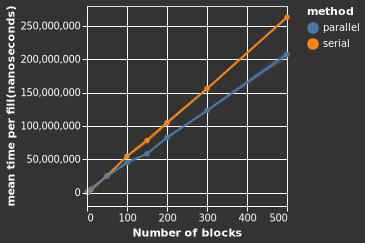

In [15]:
function timing_data(Ns, serial, parallel)
    times = DataFrame()
    for (n, strial, ptrial) in zip(Ns, serial, parallel)
        times = vcat(
            times,        
            DataFrame(
                n=repeat([n], length(strial.times) + length(ptrial.times)),
                method=vcat(
                    repeat([:serial], length(strial.times)),
                    repeat([:parallel], length(ptrial.times))
                ),
                time=vcat(strial.times, ptrial.times)
            )
        )
    end
    times
end
function plot_times(times::DataFrame)
    times |>
        @vlplot(
            config = {
                background="#333",
                title={color="#fff"},
                style={
                    "guide-label"={fill="#fff"},
                    "guide-title"={fill="#fff"},
                },
                axis={
                    domainColor="#fff",
                    gridColor="#fff",
                    tickColor="#fff"
                }
            },
            x={:n, title="Number of blocks", type=:quantitative},
            color={:method, type=:nominal}
        ) +
        @vlplot(mark={:line, point=:true}, y="mean(time)") +
        @vlplot(
            mark={:errorband, extent=:stdev},
            y={
                :time,
                title="mean time per fill(nanoseconds)",
                type=:quantitative
            }
        )
end
plot_times(Ns, serial, parallel) = (plot_times∘timing_data)(Ns, serial, parallel)
                    
plot_times(Ns, serial, parallel)

The results are rather encouraging. The behavior of both serial and parallel
versions are linear with the number of non-zero blocks, and hence with the
number of non-zero numbers entries in the matrix. This is what we hoped for.
And the parallel version is faster.

## Parallelizing matrix-vector operations

Next we try to teach the shared block-banded matrix to do matrix-vector
multiplications in parallel. First, and following the previous schema, we
create a function that will offload work to the different processes.


In [16]:
@everywhere begin
    function multiply!(
        out::SharedArray{T, 1},
        A::SharedBandedBlockBandedMatrix{T},
        x::SharedArray{T, 1}
    ) where T
        @sync begin
            for (p, proc) in enumerate(procs(A.data.blocks))
                @async remotecall_wait(multiply!, proc, out, A, x, p)
            end
        end
        A
    end
end

Then, each process figures out which blocks are assigned to it. And it calls the
multiplication operation for each particular block of the input matrix with each
particular segment of the input vector.

In [17]:
@everywhere begin
    """Populates the blocks of A that are assigned to process p."""
    function multiply!(
        out::SharedArray{T, 1},
        A::SharedBandedBlockBandedMatrix{T},
        x::SharedArray{T, 1},
        p::Integer
    ) where T
        l, u = blockbandwidths(A)
        λ, μ = subblockbandwidths(A)
        N, M = nblocks(A)

        n = sum(
            min(i + A.u, nblocks(A, 2)) -  max(i - A.l, 1) + 1
            for i in 1:nblocks(A, 1)
        )
        m = length(procs(A.data.blocks))
        start = (n ÷ m) * (p - 1) + min(n % m, p - 1)
        stop = (n ÷ m) * p + min(n % m, p)
        k = 0
        for i in 1:nblocks(A, 1), j in max(i - A.l, 1):min(i + A.u, nblocks(A, 2))
            if k >= stop
                break
            elseif k >= start
                Ablock = view(A, Block(i, j))
                muladd!(
                    one(T),
                    Ablock,
                    view(x, Ablock.indices[2].indices),
                    zero(T),
                    view(out, Ablock.indices[1].indices)
                )
            end
            k += 1
        end
        A
    end
end

The clever part is not here. The clever part is the machinery that translates
multiplying a view of a block-banded matrix and a view of a vector into
something that a
[BLAS](https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms) function
designed in the 70s can consume, i.e. a mix of integers, floating points, and
raw pointers to memory locations. That part is done by
[ArrayLayouts.jl](https://github.com/JuliaMatrices/ArrayLayouts.jl). Without
going into to many details, ArrayLayouts defines a
[trait](https://invenia.github.io/blog/2019/11/06/julialang-features-part-2/),
`MemoryLayout` which informs on how a specialized matrix is arranged in memory.
With that information, `ArrayLayout` can figure out whether it can call BLAS
directly, or whether it first needs to transform the inputs to objects with
standard memory layout:

In [18]:
MemoryLayout(typeof(A)), MemoryLayout(typeof([1.0, 2.0, 4.0]))

(BlockBandedMatrices.BandedBlockBandedColumnMajor(), ArrayLayouts.DenseColumnMajor())

What sets Julia apart from other languages is the how relatively simple it is
to extract common tropes between diverse packages and leverage them into a
single common grammar. The drawback is that we are seeing a proliferation of
small packages meant to define traits and methods for other packages
downstream. It is not clear to me what will happen as the ecosystem around
Julia gets older, and as maintainers and codes come and go. But leaving
`left-pad` behind, lets get back to shared arrays and check whether
parallelizing the matrix-vector operation has had any success:


In [19]:
n, l, u, λ, μ = 500, 1, 2, 2, 1
serial, parallel, Ns = [], [], [1, 3, 10, 50, 100, 150, 200, 300, 500]
for N = Ns
    A = SharedBandedBlockBandedMatrix{Float64}(
            undef, (repeat([n], N), repeat([n], N)), (l, u), (λ, μ))
    x = SharedArray{Float64}(rand(size(A, 1)))
    out = SharedArray{Float64}(rand(size(A, 2)))
    simplefill!(A)
    bench = @benchmark multiply!($out, $A, $x)
    push!(parallel, bench)

    B = BandedBlockBandedMatrix{Float64}(
            undef, (repeat([n], N), repeat([n], N)), (l, u), (λ, μ))
    x = rand(size(A, 1))
    out = rand(size(A, 2))
    simplefill!(B)
    bench = @benchmark muladd!(1.0, $B, $x, 0.0, $out)
    push!(serial, bench)
end

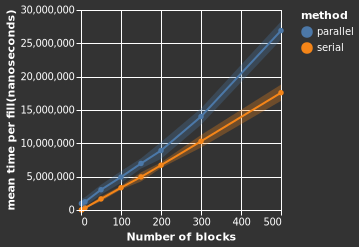

In [20]:
plot_times(Ns, serial, parallel)

Once again, the result is rather encouraging. We are getting some speedup.
Exactly how much will depend on your setup. In our case, we are using a Jupyter
notebook running on the login node of the Imperial College HPC, and results can
be a bit noisy. 

# Conclusion

We've shown how easy it can be to parallelize operations over an existing and
somewhat complicated data structure. Banded block-banded matrices are quite
specialized. It would not be surprising if we could do little to parallelize
theirs operations without digging deep into their internals and modifying the
orginal package itself. But this is Julia. We have implemented a major new
feature for banded block-banded matrices *without touching the original code*.
Even more interesting is that we have actually leveraged two disparate packages
to get the work done. We have combined `SharedArrays`' for its ability to share
arrays across processes with `BlockBandeMatrices` for its specialized matrix
type. Julia does provide speed and nerdy street-creds, but most of all its
design promotes code reuse and bottom-up, unplanned collaboration beyond
anything we've seen in any major language.

We gratefully acknowledge sponsorship from [NumFocus Open-Source
Grant](https://numfocus.org/blog/summer-2018-open-source-development-grants)
from Summer 2018. The grant allowed us to parametrize
[BlockBandedMatrices.jl](https://github.com/JuliaMatrices/BlockBandedMatrices.jl)
so that it can accept different storage backends, with the goal of pushing the
matrices onto the GPU.